In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader
from data import covid_dataset

In [2]:
with open("/home/andrea/Scrivania/Tesi/leonardo/config.yaml", 'r') as f:
    config = yaml.safe_load(f)

def get_dataset(config: yaml):

    df = pd.read_csv(os.path.join(config['paths']['data'],"aggregate/covid.csv"), index_col=0)
    y = pd.read_csv(os.path.join(config['paths']['data'],"aggregate/target.csv"), index_col=0)
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    y['data'] = pd.to_datetime(y['data'], format='%Y-%m-%d')    
    return df, y
    
df, y = get_dataset(config)
with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "rb") as f:
    adj = pickle.load(f)

In [3]:
past_step = 10
future_step = 7
if os.path.exists(f"{config['paths']['data']}/aggregate/dataset{past_step}_{future_step}.pt"):
    dataset = torch.load(f"{config['paths']['data']}/aggregate/dataset{past_step}_{future_step}.pt")
else:
    dataset = covid_dataset(df,
                            y,
                            past_step=past_step, 
                            future_step=future_step)
    torch.save(dataset, f"{config['paths']['data']}/aggregate/dataset{past_step}_{future_step}.pt")

In [4]:
batch_size = 128
generator1 = torch.Generator().manual_seed(42)
df_train, df_val, df_test = torch.utils.data.random_split(dataset=dataset, lengths = [0.7, 0.1, 0.2], generator=generator1)
dl_train = DataLoader(dataset=df_train, batch_size=batch_size)
dl_val = DataLoader(dataset=df_val, batch_size=batch_size)
dl_test = DataLoader(dataset=df_test, batch_size=batch_size)
batch, y = next(iter(dl_train))
print(batch.shape)
print(y.shape)

torch.Size([128, 1070, 10])
torch.Size([128, 7, 107])


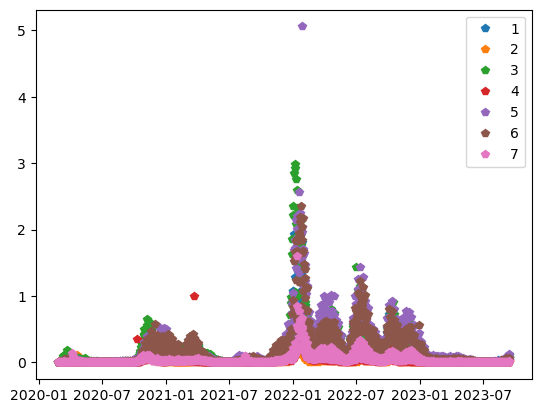

In [5]:
for codice in df.codice_regione.unique()[:7]:
    tmp = df[df.codice_regione == codice].groupby('data').sum()
    plt.plot(tmp.index, 
             tmp.nuovi_casi,'p', 
             label = codice )
plt.legend()
plt.show()

In [6]:
def step(model, 
         dataloader,
         optimizer,
         criterion,
         device,
         training: bool = False):

    if training:
        model.train()
    else:
        model.eval()
    desc = "training" if training else "validation"

    loss_epoch = 0.0
    
    for x, y in iter(dataloader):
        x = x.flatten(2).to(device).float()
        yh = model(x)
        loss = criterion(yh, y.to(device).float())

        # Backward and optimize
        if training:
            loss.backward()
            optimizer.step()
            
            # blocking the gradient summation 
            optimizer.zero_grad()

        loss_epoch += loss.item()/len(dataloader)

    return loss_epoch


def training(model, 
             train_loader, 
             val_loader, 
             num_epochs, 
             criterion,
             device,
             optimizer):
    loss_train = []
    loss_val = []
    be = np.inf
    bm = model
    
    for epoch in tqdm(range(num_epochs)):
            
        # Calculate average loss for the epoch
        loss = step(model = model, 
                         dataloader = train_loader, 
                         optimizer = optimizer, 
                         device = device,
                         criterion = criterion,
                         training = True)
        
        loss_train.append(loss)
        
        loss = step(model = model, 
                         dataloader = val_loader, 
                         optimizer = optimizer, 
                         device = device,
                         criterion = criterion,
                         training = False)
        
        loss_val.append(loss)
        
        if loss_val[-1]<be:
            be = loss_val[-1]
            bm = model
        # if epoch%10 == 0:
        #     print(f"loss epoch {epoch+1} == {loss_val[-1]}")
    return bm, loss_train, loss_val


In [7]:
# Define the LSTM cell
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights and biases
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_g = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)

        # Compute the input, forget, output, and cell gates
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined))
        g = torch.tanh(self.W_g(combined))

        # Update the cell state and hidden state
        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c
        
class LSTMModel(nn.Module):
    def __init__(self, input_size, 
                 hidden_size, 
                 past_step, 
                 future_step,
                 output_size):
        """
        input_size (int): it is the features of the input size
        hidden_size (int): it is the dimension in which the input is projected
        past_step (int): it is the number of block of LSTM whould be used 
        future_step (int): it is the number of block of LSTM whould be used 
        """
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size        # will be considered as the 
        self.past_step = past_step
        self.future_step = future_step
        self.output_size = output_size
        
        # LSTM cells for the past
        self.lstm_cells_past = LSTMCell(input_size = input_size, 
                                        hidden_size = hidden_size)
        self.fc1 = nn.Sequential(nn.Linear(hidden_size, 512), 
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 128),
                                  nn.ReLU(),
                                  nn.Linear(128, output_size))
        """
        self.lstm_cells_future = LSTMCell(input_size = output_size, 
                                          hidden_size = output_size)
        """
        self.rnn = nn.Sequential(nn.Linear(output_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, output_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Initialize hidden and cell states
        h, c = [torch.zeros(batch_size, self.hidden_size).to(x.device)] * 2

        # Iterate through LSTM layers
        for t in range(seq_len):
            h, c = self.lstm_cells_past(x[:, t, :], (h, c))
        h = self.fc1(h)
        #c = self.fc1(c)
        out = [h]
        
        for t in range(self.future_step-1):
            #h, c = self.lstm_cells_future(h, (h, c))
            h = self.rnn(h)
            out.append(h)
        out = torch.stack(out, dim = 1)
        return out

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size = batch.float().flatten(2).shape[-1], 
                 hidden_size = 128, 
                 past_step = past_step, 
                 future_step = future_step,
                 output_size = len(df.codice_provincia.unique())).to(device)
optimizer = optim.Adam(model.parameters(), 
                           lr = 1e-4)
yh = model(batch.float().flatten(2).to(device))#.shape
print(yh.shape)
print(y.shape)

torch.Size([128, 7, 107])
torch.Size([128, 7, 107])


In [14]:
model, loss_training, loss_validation = training(model, 
                                                 train_loader = dl_train, 
                                                 val_loader=dl_val, 
                                                 num_epochs = 40, 
                                                 criterion = nn.L1Loss(reduction="sum"),
                                                 optimizer = optimizer, 
                                                 device=device)

100%|███████████████████████████████████████████| 40/40 [17:11<00:00, 25.79s/it]


In [18]:
def plot(model, 
         config,
         loss_training, 
         loss_validation, 
         name,
         dl_train = dl_train,
         dl_val = dl_val, 
         show = False):
    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'], f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    batch_train, y_train = next(iter(dl_train))
    batch_val, y_val = next(iter(dl_val))
    yh_train = model(batch_train.float().to(device))
    yh_val = model(batch_val.float().to(device))

    fig, ax = plt.subplots(nrows = y.shape[1], 
                           ncols = 2, 
                           constrained_layout = True,
                           figsize = (20,10))
    for day in range(y.shape[1]):
        ax[day, 0].plot(yh_train[0,day].detach().cpu().numpy(), label ="estimate")
        ax[day, 0].plot(y_train[0,day].numpy(), label ="real")
    
        ax[day, 1].plot(yh_val[0,day].detach().cpu().numpy(), label ="estimate")
        ax[day, 1].plot(y_val[0,day].numpy(), label ="real")
        ax[day, 0].legend()
        ax[day, 1].legend()
    
        ax[day, 0].title.set_text(f"day {day +1} train")
        ax[day, 1].title.set_text(f"day {day +1} validation")
    fig.suptitle(' ComQparison between estimation and reality ', fontsize=20) 
    
    path = os.path.join(config['paths']['fig'], f"{name}.png")
    plt.savefig(path)
    if show:
        plt.show()
    plt.close(fig)


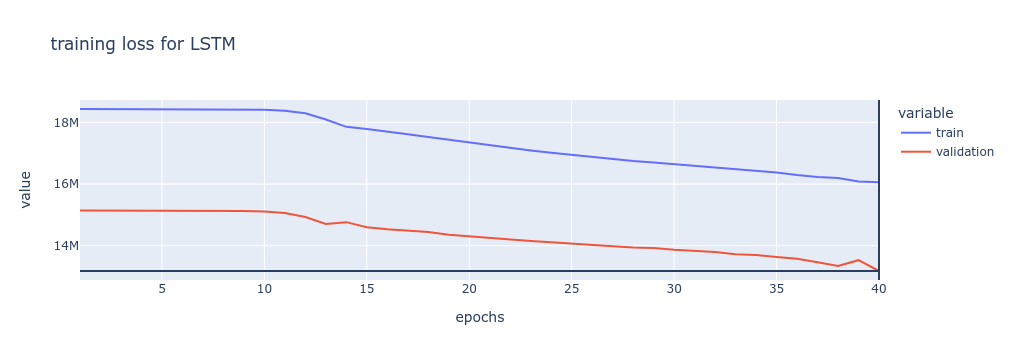

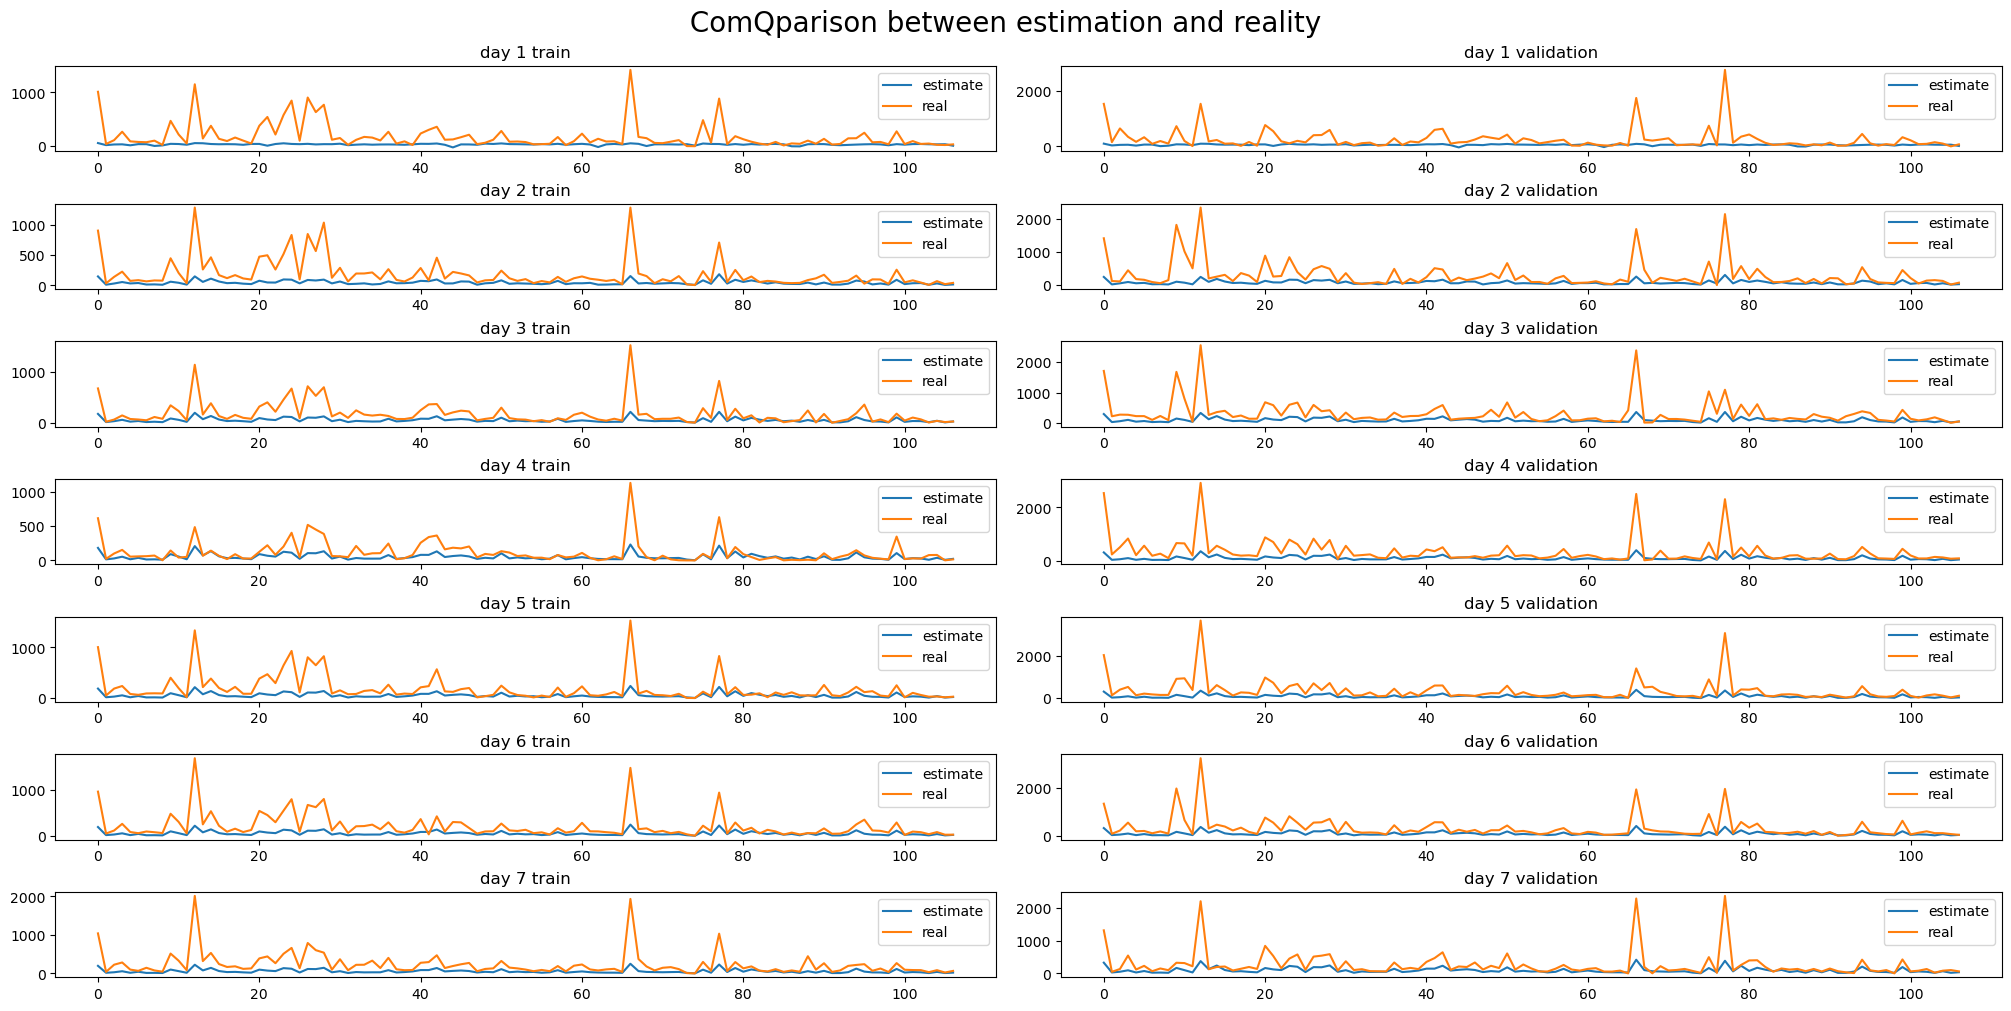

In [19]:
plot(model,
     config,
     loss_training, 
     loss_validation, 
     "LSTM", 
     show = True)